In [1]:
%load_ext autoreload
%autoreload 2

%load_ext snakeviz


In [2]:
from datetime import datetime

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import torch
import xarray
from dataset.dataset import MSGDataModule, MSGDataModulePoint, SingleImageDataset
from dataset.normalization import MinMax
from inference.estimate import MSGSingleImageDatasetOld
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from models.ConvResNet_Jiang import ConvResNet
from models.LightningModule import LitEstimator, LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [3]:
## Set Up Model

ckpt_fn = "/scratch/snx3000/kschuurm/irradiance_estimation/SIS_point_estimation/qj5zomfa/checkpoints/epoch=4-step=14520.ckpt"

dm = MSGDataModulePoint(
    batch_size=512,
    # num_workers=12,
    patch_size=(15, 15),
    input_overlap=None,
    x_vars=[
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
    ],
    y_vars=["SIS"],
    x_features=["dayofyear", "lat", "lon", "SZA", "AZI", "SRTM"],
    transform=MinMax(),
    target_transform=MinMax(),
)

# estimator = LitEstimator()
trainer = Trainer(
    # profiler="simple",
    # num_sanity_val_steps=2,
    accelerator="gpu",
    devices=-1,
    precision=16,
)

model = ConvResNet(num_attr=6, input_channels=11)

estimator = LitEstimatorPoint.load_from_checkpoint(
    ckpt_fn, learning_rate=0.01, model=model, dm=dm
)  # , model=ConvResNet(5,1), dm=dm)

/scratch/snx3000/kschuurm/pytorch/lib/python3.9/site-packages/lightning/fabric/connector.py:565: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/scratch/snx3000/kschuurm/pytorch/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/pytorch/lib/python3.9/site ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/snx3000/kschuurm/pytorch/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them

In [6]:
ds = xarray.open_zarr("/scratch/snx3000/kschuurm/DATA/HRSEVIRI.zarr")
ds_slice = ds.sel(time=datetime(2015, 5, 10, 10, 1), method="nearest").load()

config = {
    "batch_size": 512,
    "patch_size": {'x':15, 
                   'y':15,
                   'stride_x':1,
                   'stride_y':1,
                  },
    "input_overlap": None,
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
    ],
    "y_vars": ["SIS"],
    "x_features": ["dayofyear", "lat", "lon", "SZA", "AZI", "SRTM"],
    "transform": MinMax(),
    "target_transform": MinMax(),
}



dataset = SingleImageDataset(
    ds_slice,
    y_vars=config["y_vars"],
    x_vars=config["x_vars"],
    x_features=config["x_features"],
    patch_size=config["patch_size"],
    transform=config["transform"],
    target_transform=config["target_transform"],
)


<xarray.Dataset>
Dimensions:    ()
Coordinates:
    lat        float64 35.4
    lon        float64 -9.229
    time       datetime64[ns] 2015-05-10T09:57:00
Data variables:
    dayofyear  float32 0.3544
    SZA        float32 0.4321
    AZI        float32 0.2969
    SRTM       float32 0.0
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     datetime64[ns] 2015-05-10T09:57:00
    lat      float64 35.4
    lon      float64 -9.229
Data variables:
    SIS      float32 0.7502


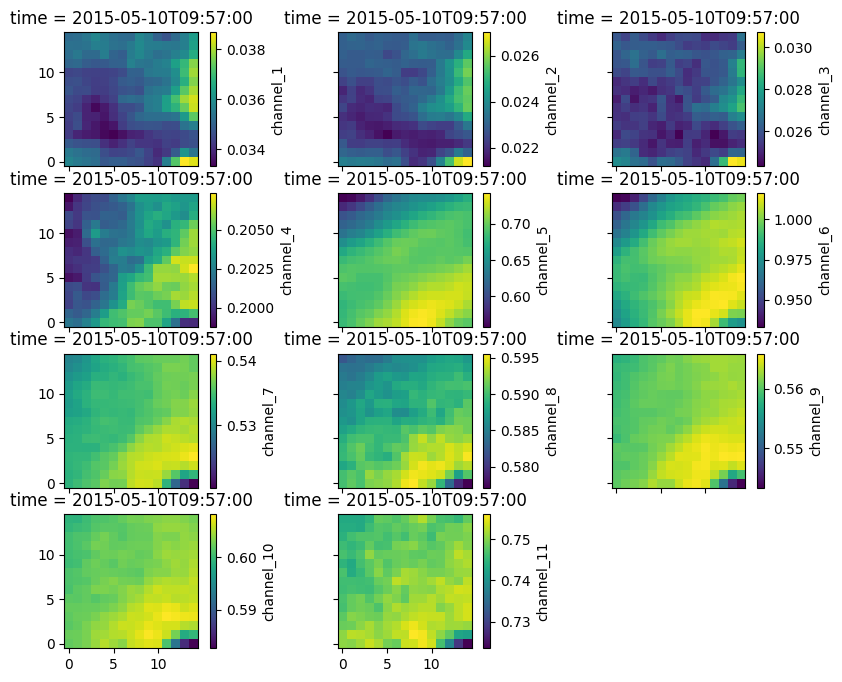

In [7]:
X, x, y = dataset.get_patch_xarray(100, transform_back=False)
print(x)
print(y)

fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(10, 8))
axs = axes.flatten()
# X = X.isel(time=0)
for i, key in enumerate(X.keys()):
    # print(X[key])
    X[key].plot.imshow(ax=axs[i], add_labels=True, add_colorbar=True)
    # axs[i].set_title('')
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].set_aspect("equal")

axs[-1].set_axis_off()
# fig.tight_layout()

In [8]:
input_dims = {"lat": 15, "lon": 15}

dataloader = DataLoader(dataset, batch_size=10000, num_workers=1)
# dataloaderold = DataLoader(dataset_old, batch_size=1000, num_workers=6)

In [9]:
# predictions, x_features
predictions = trainer.predict(estimator, dataloader)

/scratch/snx3000/kschuurm/pytorch/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/pytorch/lib/python3.9/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/snx3000/kschuurm/pytorch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# predictions2 = trainer.predict(estimator, dataloaderold)

In [12]:


def predictions_to_image(predictions, input_image, dm, patch_size): 

    y_hat = torch.vstack([x[0] for x in predictions]).squeeze()
    lat = torch.hstack([x[1][:, 1] for x in predictions])
    lon = torch.hstack([x[1][:, 2] for x in predictions])
    
    img_dim = (len(input_image.lat), len(input_image.lon))
    
    y_hat = image_1d_to_2d(y_hat, img_dim, patch_size)
    lat = image_1d_to_2d(lat, img_dim, patch_size)
    lon = image_1d_to_2d(lon, img_dim, patch_size)
    
    
    y_hat = dm.target_transform.inverse(y_hat, ["SIS"])
    lat = dm.transform.inverse(lat, ["lat"])
    lon = dm.transform.inverse(lon, ["lon"])
    
    output_image = xarray.DataArray(
        data=y_hat,
        # dims=('x','y'),
        coords={"lat": lat[:, 0], "lon": lon[0, :]},
        attrs=input_image.SIS.attrs,
    )

    output_image.lat.attrs = input_image.lat.attrs
    output_image.lon.attrs = input_image.lon.attrs
    return output_image
    

def image_1d_to_2d(arr, dim, patch_size):
    return arr.reshape(
        dim[0] - patch_size['y'] + 1,
        dim[1] - patch_size['x'] + 1,
    )

In [13]:
output_image = predictions_to_image(predictions, ds_slice, dm, config['patch_size'])
# output_image2 = predictions_to_image(predictions2, ds_slice, dm, config['patch_size'])

NameError: name 'output_image2' is not defined

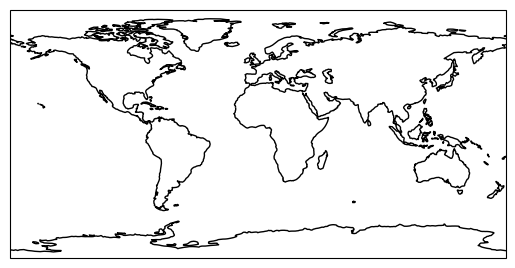

In [14]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
output_image2.plot.imshow(vmin=0, vmax=1100, ax=ax)
plt.title("DL estimator")
# plt.text(0.5, 0.05, str(input_image.time))

Text(0.5, 1.0, 'DL estimator')

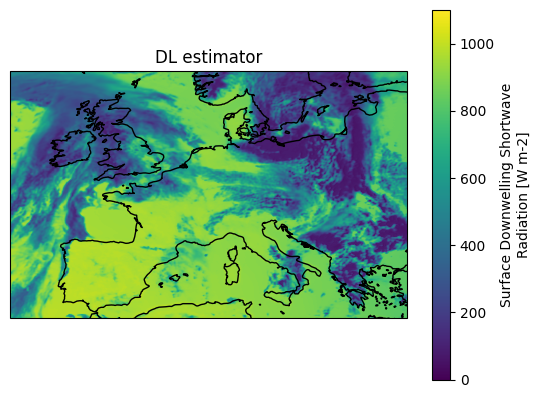

In [15]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
output_image.plot.imshow(vmin=0, vmax=1100, ax=ax)
plt.title("DL estimator")
# plt.text(0.5, 0.05, str(input_image.time))

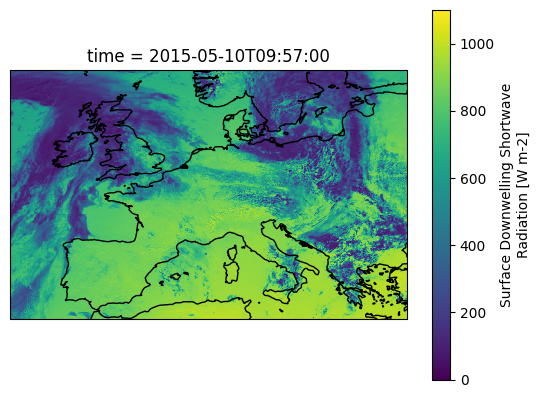

In [16]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ds_slice.SIS.plot.imshow(vmin=0, vmax=1100, ax=ax)
# plt.title("SARAH-3")

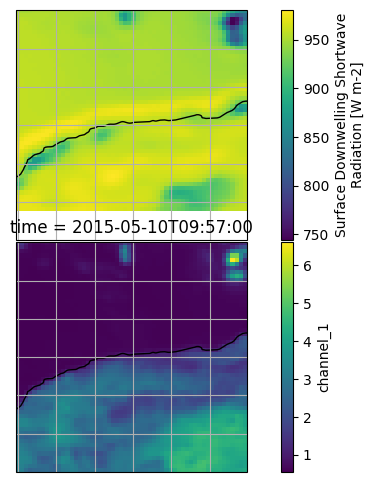

In [17]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    2,
    1,
    figsize=(9, 6),
    sharex=True,
    sharey=True,
    subplot_kw={"projection": proj, "aspect": 2},
    gridspec_kw={"wspace": 0.2, "hspace": 0.007},
)

lat = slice(35, 38)
lon = slice(0, 3)
axes[0].coastlines()
output_image.sel(
    lat=lat,
    lon=lon,
).plot.imshow(ax=axes[0])
axes[1].coastlines()
ds_slice.channel_1.sel(lat=lat, lon=lon).plot.imshow(ax=axes[1])
axes[0].gridlines()
axes[1].gridlines()

In [18]:
error = (
    ds_slice.SIS.reindex_like(output_image, method="nearest")
    - output_image
)

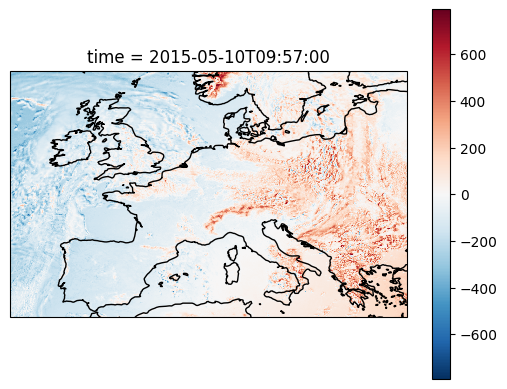

In [19]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
error.plot.imshow(ax=ax)